In [55]:
import gpflow
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf

import gpflow
from gpflow.utilities import ops, print_summary
from gpflow.config import set_default_float, default_float, set_default_summary_fmt
from gpflow.ci_utils import ci_niter

set_default_float(np.float64)
set_default_summary_fmt("notebook")

%matplotlib inline

In [93]:
data = pd.read_csv('Downloads/DataTrn.txt', sep="\s+", header=None)
labels = pd.read_csv('Downloads/DataTrnLbls.txt', sep="\s+", header=None)

In [94]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.3315,0.2156,0.6802,0.1434,0.6825,0.2720,0.6223,0.2092,0.7961,0.1530,0.5856,0.2573
1,0.0939,1.0089,0.0365,0.6944,0.0908,0.4961,0.0722,0.6521,-0.0130,0.6085,0.0631,0.6597
2,0.5184,0.2283,0.5300,0.6884,0.7456,0.6171,0.6136,0.5928,0.7678,0.6130,0.6705,0.5202
3,0.4208,0.6740,0.1651,0.7592,0.1810,0.5448,0.1707,0.7554,0.1635,0.5492,0.2598,0.6455
4,0.3130,0.6465,0.5908,0.6924,0.7664,0.6262,1.7177,0.0150,0.0851,1.9046,-0.0165,0.0221


In [95]:
labels[:][1] = labels[:][1]*2
labels[:][2] = labels[:][2]*3
lbs = labels[:][0] + labels[:][1] + labels[:][2]
lbs_use = lbs[0:100]

In [96]:
Y = tf.convert_to_tensor(data, dtype=default_float())
print("Number of points: {} and Number of dimensions: {}".format(Y.shape[0], Y.shape[1]))
Y = Y[0:100,:]
print("Number of points: {} and Number of dimensions: {}".format(Y.shape[0], Y.shape[1]))
labels = tf.convert_to_tensor(lbs_use)
print(labels)

Number of points: 1000 and Number of dimensions: 12
Number of points: 100 and Number of dimensions: 12
tf.Tensor(
[1. 2. 1. 2. 3. 2. 3. 3. 3. 3. 2. 2. 1. 3. 2. 1. 3. 1. 1. 2. 2. 1. 3. 3.
 2. 2. 2. 2. 3. 1. 3. 3. 2. 2. 2. 2. 1. 1. 2. 1. 1. 3. 3. 2. 1. 3. 2. 1.
 3. 1. 2. 2. 2. 3. 3. 3. 1. 3. 3. 2. 1. 3. 2. 3. 1. 3. 2. 2. 3. 2. 3. 3.
 1. 3. 2. 1. 1. 3. 2. 3. 2. 2. 1. 2. 1. 3. 1. 2. 1. 1. 3. 2. 3. 3. 2. 2.
 3. 3. 2. 1.], shape=(100,), dtype=float64)


In [97]:
latent_dim = 2  # number of latent dimensions
num_inducing = 20  # number of inducing pts
num_data = Y.shape[0]  # number of data points

In [98]:
X_mean_init = ops.pca_reduce(Y, latent_dim)
X_var_init = tf.ones((num_data, latent_dim), dtype=default_float())

In [99]:
np.random.seed(1)  # for reproducibility
inducing_variable = tf.convert_to_tensor(
    np.random.permutation(X_mean_init.numpy())[:num_inducing], dtype=default_float()
)

In [100]:
lengthscales = tf.convert_to_tensor([1.0] * latent_dim, dtype=default_float())
kernel = gpflow.kernels.RBF(lengthscales=lengthscales)

In [101]:
gplvm = gpflow.models.BayesianGPLVM(
    Y,
    X_data_mean=X_mean_init,
    X_data_var=X_var_init,
    kernel=kernel,
    inducing_variable=inducing_variable,
)

In [102]:
gplvm.likelihood.variance.assign(0.01)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-4.600266525158521>

In [103]:
opt = gpflow.optimizers.Scipy()
maxiter = ci_niter(1000)
_ = opt.minimize(
    gplvm.training_loss,
    method="BFGS",
    variables=gplvm.trainable_variables,
    options=dict(maxiter=maxiter),
)

In [104]:
print_summary(gplvm)

name,class,transform,prior,trainable,shape,dtype,value
BayesianGPLVM.kernel.variance,Parameter,Softplus,,True,(),float64,0.6730002184616484
BayesianGPLVM.kernel.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[0.89408714 1.404158 ]
BayesianGPLVM.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.007442818380238797
BayesianGPLVM.X_data_mean,Parameter,Identity,,True,"(100, 2)",float64,"[[-6.69411615e-01, 3.49844962e-01..."
BayesianGPLVM.X_data_var,Parameter,Softplus,,True,"(100, 2)",float64,"[[0.00150787, 0.00098478..."
BayesianGPLVM.inducing_variable.Z,Parameter,Identity,,True,"(20, 2)",float64,"[[1.77842483e+00, -1.18659986e-01..."


[[-6.69411615e-01  3.49844962e-01]
 [-1.00935521e+00 -6.58322981e-01]
 [-3.67060204e-01  2.35636444e-01]
 [-1.24714025e+00 -4.56385511e-01]
 [ 1.75470392e+00  7.03513421e-02]
 [-1.42551434e+00  8.06796018e-02]
 [-6.89495100e-01 -2.13678837e+00]
 [-7.37426629e-01 -2.05597874e+00]
 [ 2.27930714e-01  1.81656634e+00]
 [-5.74631419e-01  2.40845736e+00]
 [ 5.26436069e-01  6.56308265e-01]
 [-1.36647845e+00 -4.22610417e-01]
 [-5.26977918e-01 -2.41114631e-01]
 [ 1.76050767e+00  5.89992196e-01]
 [-1.24837177e+00  3.64102363e-01]
 [-2.39516021e-01  1.00528705e-01]
 [ 1.78189907e+00  5.09661702e-02]
 [-7.62047294e-01 -8.85342481e-02]
 [-8.18817032e-01  1.14200738e-03]
 [-1.56890538e+00  1.36757768e+00]
 [ 7.26034746e-01  5.63515936e-01]
 [-1.01683882e-01  4.57926103e-01]
 [ 1.15714669e+00  1.78055656e+00]
 [-6.74097480e-01 -1.96814040e+00]
 [-7.75485499e-01 -9.25783584e-01]
 [-1.07605645e+00  2.00817500e-01]
 [-9.80391914e-01 -7.50229753e-01]
 [ 3.40441117e-01  3.62885024e-01]
 [ 1.66095199e+00 -1

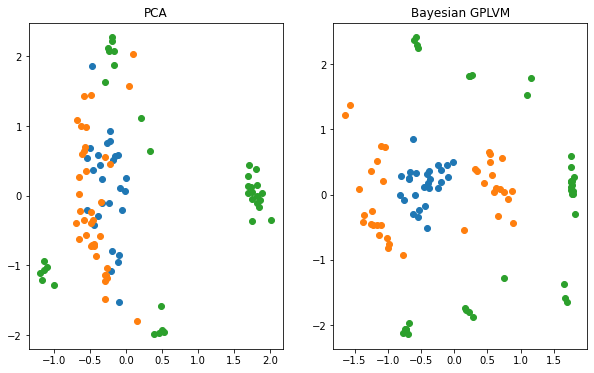

In [105]:
X_pca = ops.pca_reduce(Y, latent_dim).numpy()
gplvm_X_mean = gplvm.X_data_mean.numpy()

print(gplvm_X_mean)

f, ax = plt.subplots(1, 2, figsize=(10, 6))

for i in np.unique(labels):
    ax[0].scatter(X_pca[labels == i,0], X_pca[labels == i,1], label=i)
    ax[1].scatter(gplvm_X_mean[labels == i, 0], gplvm_X_mean[labels == i, 1], label=i)
    ax[0].set_title("PCA")
    ax[1].set_title("Bayesian GPLVM")

In [106]:
print(np.unique(labels))
len(X_pca)

[1. 2. 3.]


100